# Biodivine Network Analysis Summary

This notebook analyzes selected biological Boolean networks from biodivine:
- bn_109_5d.py (Caulobacter cell cycle)
- bn_158_7d.py (Phage lambda decision)
- bn_063_10d_011.py (Embryonic development)

Examining:
- Number of attractors
- Other SCCs (non-attractor)
- Parentless nodes
- SCC interconnection structure

In [2]:
import os
import sys
from pathlib import Path
from collections import defaultdict
import pandas as pd
import importlib.util

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

In [3]:
def load_network(filepath):
    """Load a network from a Python file."""
    spec = importlib.util.spec_from_file_location("network", filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    
    if hasattr(module, 'transitions'):
        return module.transitions, getattr(module, 'network_functions', None)
    elif hasattr(module, 'network_functions'):
        # Need to compute transitions from functions
        return None, module.network_functions
    return None, None

In [4]:
def find_sccs(transitions):
    """Find strongly connected components using iterative Tarjan's algorithm."""
    index_counter = [0]
    stack = []
    lowlinks = {}
    index = {}
    on_stack = {}
    sccs = []
    
    for start_node in transitions:
        if start_node in index:
            continue
        
        call_stack = [(start_node, None, 0)]
        
        while call_stack:
            node, successor_iter, phase = call_stack.pop()
            
            if phase == 0:
                index[node] = index_counter[0]
                lowlinks[node] = index_counter[0]
                index_counter[0] += 1
                stack.append(node)
                on_stack[node] = True
                successor_iter = iter(transitions.get(node, []))
                call_stack.append((node, successor_iter, 1))
            else:
                try:
                    successor = next(successor_iter)
                    call_stack.append((node, successor_iter, 1))
                    if successor not in index:
                        call_stack.append((successor, None, 0))
                    elif on_stack.get(successor, False):
                        lowlinks[node] = min(lowlinks[node], index[successor])
                except StopIteration:
                    if lowlinks[node] == index[node]:
                        scc = set()
                        while True:
                            successor = stack.pop()
                            on_stack[successor] = False
                            scc.add(successor)
                            if successor == node:
                                break
                        sccs.append(scc)
                    if call_stack:
                        parent_node = call_stack[-1][0]
                        if parent_node in lowlinks:
                            lowlinks[parent_node] = min(lowlinks[parent_node], lowlinks[node])
    return sccs

In [8]:
def analyze_network(transitions):
    """Analyze network structure."""
    all_states = set(transitions.keys())
    
    # Find all target states
    all_targets = set()
    for targets in transitions.values():
        all_targets.update(targets)
    
    # Parentless states (no incoming edges)
    parentless = all_states - all_targets
    
    # Fixed points (self-loops only)
    fixed_points = [s for s, targets in transitions.items() if targets == [s]]
    
    # Find SCCs
    sccs = find_sccs(transitions)
    
    # Identify attractors (SCCs with no exit)
    attractors = []
    transient_sccs = []
    
    for scc in sccs:
        has_exit = False
        for state in scc:
            for target in transitions.get(state, []):
                if target not in scc:
                    has_exit = True
                    break
            if has_exit:
                break
        if not has_exit:
            attractors.append(scc)
        else:
            transient_sccs.append(scc)
    
    # Build SCC graph (condensation)
    state_to_scc = {}
    for i, scc in enumerate(sccs):
        for state in scc:
            state_to_scc[state] = i
    
    scc_edges = set()
    for state, targets in transitions.items():
        src_scc = state_to_scc[state]
        for target in targets:
            dst_scc = state_to_scc[target]
            if src_scc != dst_scc:
                scc_edges.add((src_scc, dst_scc))
    
    return {
        'num_states': len(all_states),
        'num_transitions': sum(len(t) for t in transitions.values()),
        'parentless_states': len(parentless),
        'fixed_points': len(fixed_points),
        'num_sccs': len(sccs),
        'num_attractors': len(attractors),
        'attractor_sizes': sorted([len(a) for a in attractors], reverse=True),
        'num_transient_sccs': len(transient_sccs),
        'transient_scc_sizes': sorted([len(s) for s in transient_sccs], reverse=True)[:10],
        'scc_edges': len(scc_edges),
    }

In [7]:
# Define the specific biodivine networks to analyze
base_dir = Path.cwd()

# Selected biological networks
selected_networks = [
    {'name': 'bn_109_5d', 'path': base_dir / '5d' / 'bn_109_5d.py', 'dimension': 5, 'description': 'Caulobacter cell cycle'},
    {'name': 'bn_158_7d', 'path': base_dir / '7d' / 'bn_158_7d.py', 'dimension': 7, 'description': 'Phage lambda decision'},
    {'name': 'bn_063_10d_011', 'path': base_dir / '10d' / 'bn_063_10d_011.py', 'dimension': 10, 'description': 'Embryonic development'},
]

print(f"Analyzing {len(selected_networks)} biodivine networks:\n")
for net in selected_networks:
    print(f"  - {net['name']} ({net['dimension']}D): {net['description']}")

Analyzing 3 biodivine networks:

  - bn_109_5d (5D): Caulobacter cell cycle
  - bn_158_7d (7D): Phage lambda decision
  - bn_063_10d_011 (10D): Embryonic development


In [9]:
# Analyze all selected networks
import re

results = []

for net in selected_networks:
    try:
        transitions, functions = load_network(net['path'])
        if transitions is None:
            print(f"Skipping {net['name']}: no transitions found")
            continue
        
        analysis = analyze_network(transitions)
        
        # Extract model ID from filename (e.g., bn_109_5d.py -> 109)
        id_match = re.search(r'bn_(\d+)', net['name'])
        model_id = int(id_match.group(1)) if id_match else 0
        
        results.append({
            'dimension': net['dimension'],
            'model_id': model_id,
            'name': net['name'],
            'description': net['description'],
            **analysis
        })
        print(f"✓ Analyzed {net['name']}")
    except Exception as e:
        print(f"Error analyzing {net['name']}: {e}")

print(f"\nSuccessfully analyzed {len(results)} networks")

✓ Analyzed bn_109_5d
✓ Analyzed bn_158_7d
✓ Analyzed bn_063_10d_011

Successfully analyzed 3 networks


In [11]:
# Create summary DataFrame
df = pd.DataFrame(results)

# Display summary
summary_cols = ['dimension', 'model_id', 'description', 'num_states', 'parentless_states', 
                'fixed_points', 'num_attractors', 'num_transient_sccs', 'scc_edges']
df[summary_cols]

,dimension,model_id,description,num_states,parentless_states,fixed_points,num_attractors,num_transient_sccs,scc_edges
0,5,109,Caulobacter cell cycle,32,1,1,1,7,13
1,7,158,Phage lambda decision,128,1,1,2,79,294
2,10,63,Embryonic development,1024,1,1,1,704,3723


In [12]:
# Detailed attractor information
print("=" * 80)
print("BIODIVINE NETWORK DETAILS")
print("=" * 80)

for _, row in df.iterrows():
    print(f"\n{row['name']} - {row['description']}")
    print(f"  Dimension: {row['dimension']}D ({row['num_states']} states)")
    print(f"  Parentless states: {row['parentless_states']}")
    print(f"  Fixed points: {row['fixed_points']}")
    print(f"  Attractors: {row['num_attractors']} (sizes: {row['attractor_sizes']})")
    print(f"  Transient SCCs: {row['num_transient_sccs']}")
    if row['transient_scc_sizes']:
        print(f"  Largest transient SCCs: {row['transient_scc_sizes']}")
    print(f"  SCC interconnections: {row['scc_edges']} edges")

BIODIVINE NETWORK DETAILS

bn_109_5d - Caulobacter cell cycle
  Dimension: 5D (32 states)
  Parentless states: 1
  Fixed points: 1
  Attractors: 1 (sizes: [1])
  Transient SCCs: 7
  Largest transient SCCs: [25, 1, 1, 1, 1, 1, 1]
  SCC interconnections: 13 edges

bn_158_7d - Phage lambda decision
  Dimension: 7D (128 states)
  Parentless states: 1
  Fixed points: 1
  Attractors: 2 (sizes: [2, 1])
  Transient SCCs: 79
  Largest transient SCCs: [31, 11, 4, 2, 2, 2, 1, 1, 1, 1]
  SCC interconnections: 294 edges

bn_063_10d_011 - Embryonic development
  Dimension: 10D (1024 states)
  Parentless states: 1
  Fixed points: 1
  Attractors: 1 (sizes: [1])
  Transient SCCs: 704
  Largest transient SCCs: [221, 100, 1, 1, 1, 1, 1, 1, 1, 1]
  SCC interconnections: 3723 edges


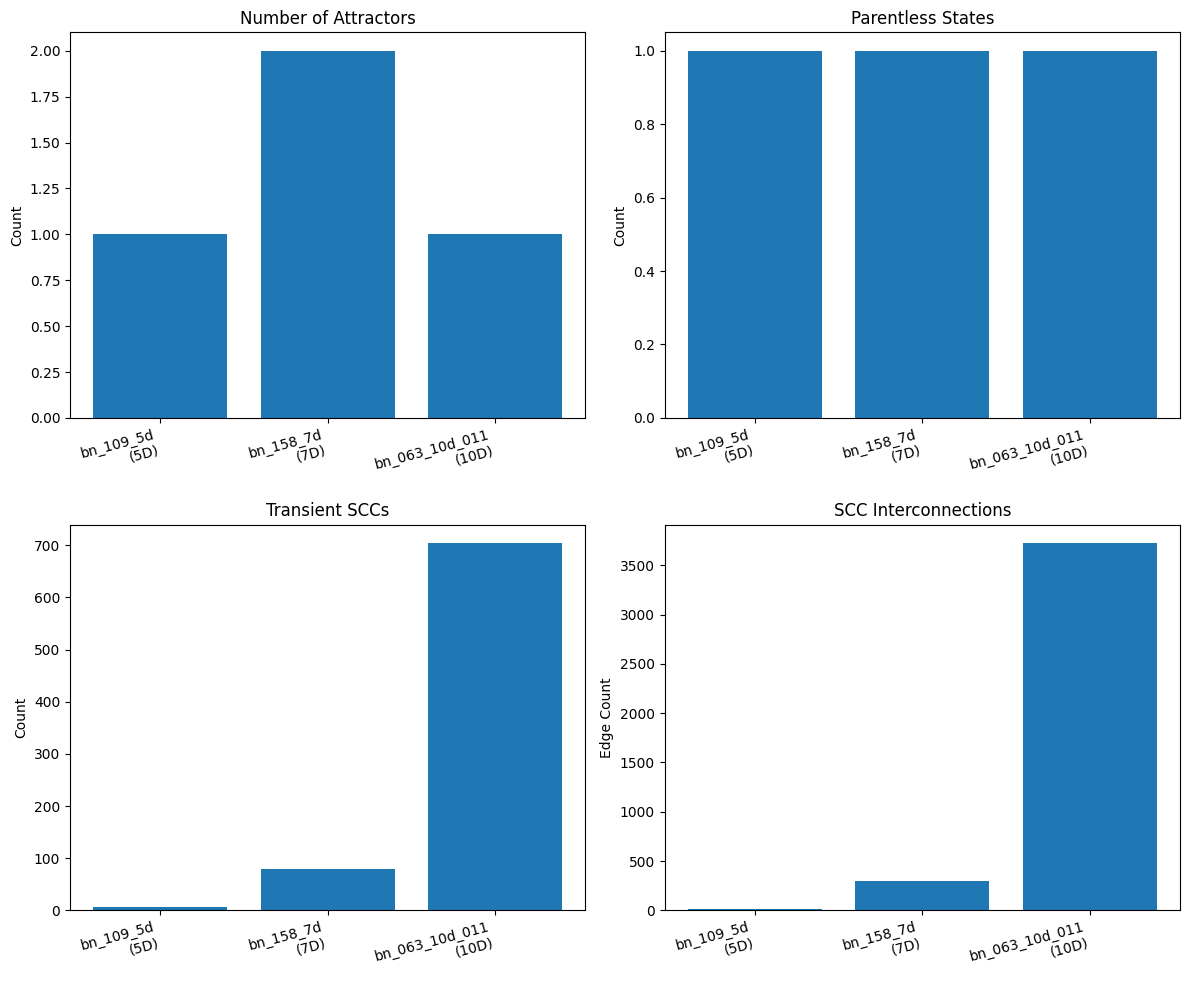

In [13]:
# Visualize comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

labels = [f"{row['name']}\n({row['dimension']}D)" for _, row in df.iterrows()]
x = range(len(labels))

# Number of attractors
ax1 = axes[0, 0]
ax1.bar(x, df['num_attractors'])
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=15, ha='right')
ax1.set_title('Number of Attractors')
ax1.set_ylabel('Count')

# Parentless states
ax2 = axes[0, 1]
ax2.bar(x, df['parentless_states'])
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=15, ha='right')
ax2.set_title('Parentless States')
ax2.set_ylabel('Count')

# Transient SCCs
ax3 = axes[1, 0]
ax3.bar(x, df['num_transient_sccs'])
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=15, ha='right')
ax3.set_title('Transient SCCs')
ax3.set_ylabel('Count')

# SCC interconnections
ax4 = axes[1, 1]
ax4.bar(x, df['scc_edges'])
ax4.set_xticks(x)
ax4.set_xticklabels(labels, rotation=15, ha='right')
ax4.set_title('SCC Interconnections')
ax4.set_ylabel('Edge Count')

plt.tight_layout()
plt.show()

In [14]:
# Save results to CSV
output_path = base_dir / 'biodivine_analysis_results.csv'
df_export = df.drop(columns=['name'], errors='ignore')
df_export.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to /Users/marcinnowakowski/mimuw/sad2/boolean_bayesian_networks/networks/functions/biodivine/biodivine_analysis_results.csv
